# 7-3 신경망 모델 훈련

## 손실 곡선

In [1]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

In [3]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
model = model_fn()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

history 객체 안에 훈련 측정값이 담겨있음

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


### 손실함수 시각화

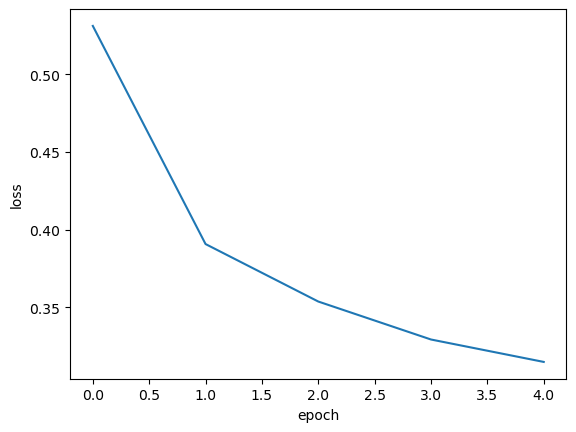

In [7]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### 정확도 시각화

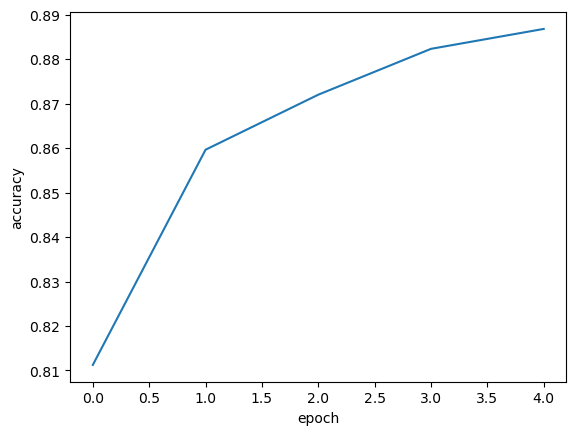

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

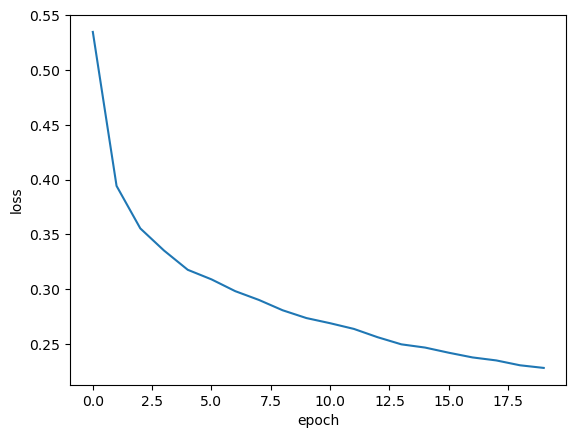

In [12]:

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 검증 손실

인공 신경망도 경사 하강법을 사용하기 때문에 과대/과소적합과 에포크의 관계에 대해 살필 필요가 있다.


이때 검증데이터에 대한 정확도도 필요하므로 검증 데이터도 함께 사용

In [13]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


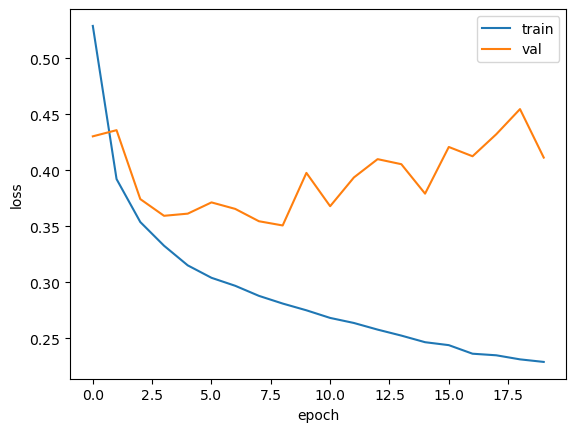

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실이 감소하다가 다시 상승하는 모양. 훈련 손실은 꾸준히 감소하므로 과대적합 모델로 볼 수 있음.

이러한 과대적합 문제를 옵티마이저를 통해 완화시킬 수 있을까?

In [16]:
# Adam 옵티마이저 적용

model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

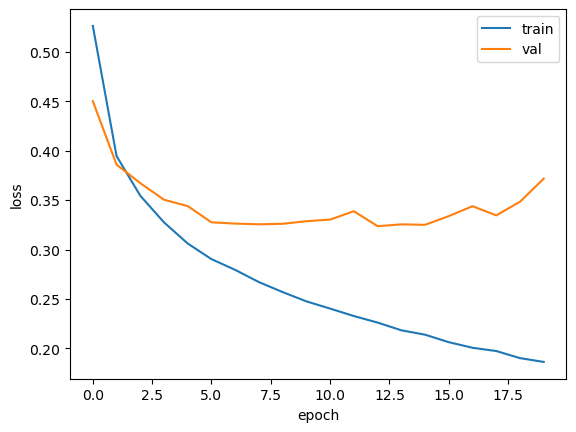

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 손실 그래프에 요동이 남아 있지만 전반적으로 감소하는 추세. RMSprop보다 Adam 옵티마이저가 해당 데이터셋에 더 잘 맞는다는 뜻.

# 드롭아웃

훈련 과정 중 층에 있는 뉴런을 랜덤하게 꺼저(출력을 0으로 만들어서) 과대적합을 막는 방법이다. 랜덤하게 드롭되며 얼마나 많은 뉴런을 드롭할지는 또 다른 하이퍼 파라미터값이 된다.


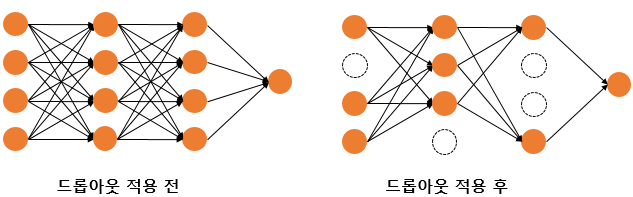


두 개의 신경망을 앙상블 하는 것 같은 효과. keras.laters 패키지 아래 Dropout 클래스 제공 중. 어떤 층 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로 만드는 것 = 드롭 아웃. 드롭아웃은 층처럼 사용되나 훈련 되는 모델 파라미터(Param에 값이 0인 것을 확인)가 없다.


In [18]:
# 뉴런의 30% 정도를 드롭 아웃

model = model_fn(keras.layers.Dropout(0.3))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


또한 일부 뉴런의 출력을 0으로 만들었지만 전체 출력 배열의 크기(Total params)는 바꾸지 않는다.

### 드롭아웃 주의점

훈련이 끝난 뒤 평가나 예측 수행시에는 드롭아웃을 적용하지 말아야 한다.(텐서와 케라스는 자동으로 적용하지 않는다)

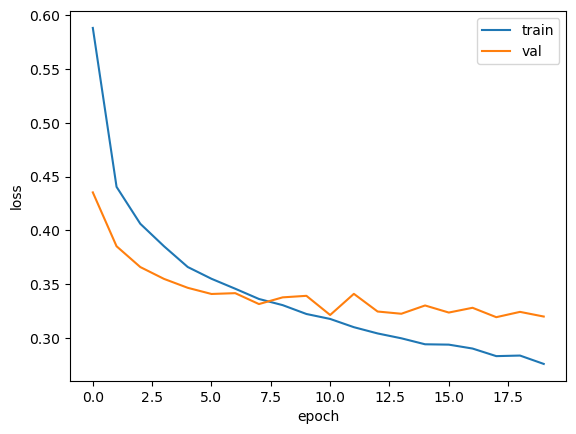

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 모델 저장과 복원


* 모델에서 훈련된 모델 파라미터를 저장하기:`save_weights()`
* 모델 구조와 모델 파라미터를 함께 저장: `save()`

In [47]:
#pip install h5py==2.10.0

pip install h5py==2.10.0

에러발생으로 `oad_model`부터 코드 진행 불가

In [39]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=10, verbose=0, 
                    validation_data=(val_scaled, val_target))

In [40]:
model.save_weights('model-weights.h5')

In [41]:
model.save('model-whole.h5')

In [42]:
!ls -al *.h5

'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [43]:
model = model_fn(keras.layers.Dropout(0.3))

model.load_weights('model-weights.h5')

훈련 하지 않은 model 객체를 만들고 이전에 저장한 모델 파라미터를 적재 `load_weight`

### 모델의 정확도 계산

* `evalueate()` 메서드를 사용하지 않는 이유는 evalueate를 쓰려면 먼저 compile 메서드를 실행해야 하기 때문임.


모델의 predict() 결과값에서 가장 큰 값을 고르기 위해 `argmax()`함수 사용. 배열에서 가장 큰 값의 인덱스를 반환

axis = -1은 배열의 마지막 차원을 따라 최댓값을 고름. 검증 세트는 2차원 배열이기 때문에 마지막 차원은 1이 됨. 

In [28]:
import numpy as np

val_labels = np.argmax(model.predict(val_scaled), axis=-1)
print(np.mean(val_labels == val_target))

375/375 [==============================] - 0s 931us/step
0.8779166666666667


In [44]:
model = keras.models.load_model('model-whole.h5')

model.evaluate(val_scaled, val_target)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 23: invalid start byte

# 콜백

ModelCheckpoint 콜백은 에포크마다 모델저장.

save_best_only=True 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음

In [36]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, 
          validation_data=(val_scaled, val_target),
          callbacks=[checkpoint_cb])

In [37]:
model = keras.models.load_model('best-model.h5')

model.evaluate(val_scaled, val_target)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xfc in position 23: invalid start byte

###  조기종료 조건 추가

에포크 횟수 제한 과대적합을 억제하는 간접 효가.

In [ ]:

model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
print(early_stopping_cb.stopped_epoch)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 정리

|키워드|내용|
|------|---|
|드롭아웃|은닉층에 있는 뉴런을 랜덤하게 드롭하여 과대적합을 막는 기법|
|콜백|케라스 모델에서 훈련 도중 작업 수행을 돕는 도구. 최상 모델을 자동 저장해주거나 검증 점수가 향상되지 않을때 조기종료해주는 게 대표적이다|
|조기 종료|검증 점수가 더이상 감소하지 않고 상승하여 과대접합이 일어나면 훈련을 중지하는 기법.



|TensorFlow|내용|
|------|---|
|save_weights|모든 층의 가중치와 절편을 파일에 저장|
|load_weights|모든 층의 가중치와 절편을 파일에 읽어오기|
|save|모델 구조와 모든 층의 가중치와 절편을 파일에 저장|
|load_model|model.save()로 저장된 모델 로드|
|ModelCheckpoint|케라스 모델과 가중치를 일정 간격으로 저장|
|EarlyStopping|관심 지표가 더이상 향상하지 않으면 훈련을 중지. 조기종료|